# Supervised training for RANS flows around airfoils

AIAA airfoil supervised training notebook...

TODO:
- add graphs for training
- test eval


In [ ]:
# data
from torch.utils.data import Dataset
import torch
import numpy as np
# ? from os import listdir
import os.path
import random

print("Torch version {}".format(torch.__version__))

if not os.path.isfile('data.npz'):
  import urllib.request
  url="https://ge.in.tum.de/download/2019-deepFlowPred/data.npz"
  print("Downloading training data (300MB), this can take a few minutes the first time...")
  urllib.request.urlretrieve(url, 'data.npz')

npfile=np.load("data.npz")
print("Loaded data, {} training, {} validation samples".format(len(npfile["inputs"]),len(npfile["vinputs"])))

print("Size of the inputs array: "+format(npfile["inputs"].shape))


Torch version 1.7.0+cu101
Loaded data, 320 training, 80 validation samples
Size of the inputs array: (320, 3, 128, 128)


Let's look at one of the training samples... (Just helper code to show images side by side).


Here are all 3 inputs (mask,in x, in y) side by side with the 3 output channels (p,vx,vy):


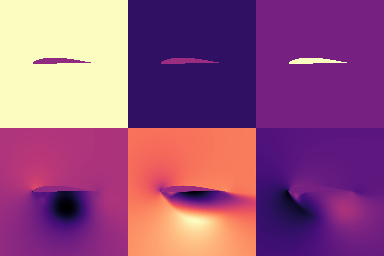

In [ ]:
from PIL import Image
from matplotlib import cm

def show(a, stats=False): # helper to show three target channels, normalized with colormap
  for i in range(3):
    b = np.flipud(a[i].transpose())
    min,mean,max = np.min(b),np.mean(b),np.max(b); 
    if stats: print([b[0,0],min,mean,max])
    b -= min; b /= (max-min)
    if stats: print("{}".format(["p:","ux:","uy:"][i])) # note, for inputs the first channel is the mask...
    display(Image.fromarray( cm.magma(b, bytes=True) ))

def showSbs(a1,a2, stats=False): # helper to show three target channels, normalized with colormap side by side
  c=[]
  for i in range(3):
    b = np.flipud( np.concatenate((a2[i],a1[i]),axis=1).transpose())
    min, mean, max = np.min(b), np.mean(b), np.max(b); 
    if stats: print([b[0,0],min,mean,max])
    b -= min; b /= (max-min)
    c.append(b)
  c = np.concatenate(c,axis=1)
  display(Image.fromarray( cm.magma(c, bytes=True) ))

num=72
print("\nHere are all 3 inputs (mask,in x, in y) side by side with the 3 output channels (p,vx,vy):")
showSbs(npfile["inputs"][num],npfile["targets"][num])


Next, small helper class `DfpDataset` to store inputs and targets. Transfer to pytorch `DataLoader` class. 

Also set up some globals to control training parameters, maybe most important: learning rate `lr`, keep relatively small (learning rate decay would be better, i.e. give slightly faster training, but is omitted here for clarity). Expo controls the exponent for feature maps - this scales the network size (3 gives a model with ca. 150k parameters). This is relatively small for a generative model for $3 \times 128^2$ outputs.

In [ ]:
# global training parameters

# number of training epochs
epochs = 100
# batch size
batch_size = 10
# learning rate
lr = 0.00002
# channel exponent to control network size
expo = 3

class DfpDataset():
    def __init__(self, inputs,targets): 
        self.inputs  = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

tdata = DfpDataset(npfile["inputs"],npfile["targets"])
vdata = DfpDataset(npfile["vinputs"],npfile["vtargets"])

trainLoader = torch.utils.data.DataLoader(tdata, batch_size=batch_size, shuffle=True , drop_last=True) 
valiLoader  = torch.utils.data.DataLoader(vdata, batch_size=batch_size, shuffle=False, drop_last=True) 

print("Training & validation batches: {} , {}".format(len(trainLoader),len(valiLoader) ))

Training & validation batches: 32 , 8


## Network setup

Now we can set up the network architecture, we'll use a U-net. TODO, add picture. 

Helpers to set up a convolutional block in the network. Note, no pooling! Use strides and transpose convolutions (need to be symmetric for the decoder part, i.e. uneven kernel size).

In [ ]:
import os, sys, random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd 
import torch.utils.data 

def blockUNet(in_c, out_c, name, transposed=False, bn=True, relu=True, size=4, pad=1, dropout=0.):
    block = nn.Sequential()

    if relu:
        block.add_module('%s_relu' % name, nn.ReLU(inplace=True))
    else:
        block.add_module('%s_leakyrelu' % name, nn.LeakyReLU(0.2, inplace=True))

    if not transposed:
        block.add_module('%s_conv' % name, nn.Conv2d(in_c, out_c, kernel_size=size, stride=2, padding=pad, bias=True))
    else:
        block.add_module('%s_upsam' % name, nn.Upsample(scale_factor=2))
        # reduce kernel size by one for the upsampling (ie decoder part)
        block.add_module('%s_tconv' % name, nn.Conv2d(in_c, out_c, kernel_size=(size-1), stride=1, padding=pad, bias=True))

    if bn:
        block.add_module('%s_bn' % name, nn.BatchNorm2d(out_c))
    if dropout>0.:
        block.add_module('%s_dropout' % name, nn.Dropout2d( dropout, inplace=True))

    return block
    
class DfpNet(nn.Module):
    def __init__(self, channelExponent=6, dropout=0.):
        super(DfpNet, self).__init__()
        channels = int(2 ** channelExponent + 0.5)

        self.layer1 = nn.Sequential()
        self.layer1.add_module('layer1', nn.Conv2d(3, channels, 4, 2, 1, bias=True))

        self.layer2 = blockUNet(channels  , channels*2, 'layer2', transposed=False, bn=True,  relu=False, dropout=dropout )
        self.layer2b= blockUNet(channels*2, channels*2, 'layer2b',transposed=False, bn=True,  relu=False, dropout=dropout )
        self.layer3 = blockUNet(channels*2, channels*4, 'layer3', transposed=False, bn=True,  relu=False, dropout=dropout )
        self.layer4 = blockUNet(channels*4, channels*8, 'layer4', transposed=False, bn=True,  relu=False, dropout=dropout ) 
        self.layer5 = blockUNet(channels*8, channels*8, 'layer5', transposed=False, bn=True,  relu=False, dropout=dropout , size=2,pad=0)
        self.layer6 = blockUNet(channels*8, channels*8, 'layer6', transposed=False, bn=False, relu=False, dropout=dropout , size=2,pad=0)
     
        # note, kernel size is internally reduced by one for the decoder part
        self.dlayer6 = blockUNet(channels*8, channels*8, 'dlayer6', transposed=True, bn=True, relu=True, dropout=dropout , size=2,pad=0)
        self.dlayer5 = blockUNet(channels*16,channels*8, 'dlayer5', transposed=True, bn=True, relu=True, dropout=dropout , size=2,pad=0)
        self.dlayer4 = blockUNet(channels*16,channels*4, 'dlayer4', transposed=True, bn=True, relu=True, dropout=dropout ) 
        self.dlayer3 = blockUNet(channels*8, channels*2, 'dlayer3', transposed=True, bn=True, relu=True, dropout=dropout )
        self.dlayer2b= blockUNet(channels*4, channels*2, 'dlayer2b',transposed=True, bn=True, relu=True, dropout=dropout )
        self.dlayer2 = blockUNet(channels*4, channels  , 'dlayer2', transposed=True, bn=True, relu=True, dropout=dropout )

        self.dlayer1 = nn.Sequential()
        self.dlayer1.add_module('dlayer1_relu', nn.ReLU(inplace=True))
        self.dlayer1.add_module('dlayer1_tconv', nn.ConvTranspose2d(channels*2, 3, 4, 2, 1, bias=True))

    def forward(self, x):
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        out2b= self.layer2b(out2)
        out3 = self.layer3(out2b)
        out4 = self.layer4(out3)
        out5 = self.layer5(out4)
        out6 = self.layer6(out5)
        dout6 = self.dlayer6(out6)
        dout6_out5 = torch.cat([dout6, out5], 1)
        dout5 = self.dlayer5(dout6_out5)
        dout5_out4 = torch.cat([dout5, out4], 1)
        dout4 = self.dlayer4(dout5_out4)
        dout4_out3 = torch.cat([dout4, out3], 1)
        dout3 = self.dlayer3(dout4_out3)
        dout3_out2b = torch.cat([dout3, out2b], 1)
        dout2b = self.dlayer2b(dout3_out2b)
        dout2b_out2 = torch.cat([dout2b, out2], 1)
        dout2 = self.dlayer2(dout2b_out2)
        dout2_out1 = torch.cat([dout2, out1], 1)
        dout1 = self.dlayer1(dout2_out1)
        return dout1

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)



Initialize net...

In [ ]:
# setup network
net = DfpNet(channelExponent=expo, dropout=0.)
#print(net) # to double check the details...

model_parameters = filter(lambda p: p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Trainable params: {}".format(params)) # crucial parameter to keep in view: how many parameters do we have?

net.apply(weights_init)

criterionL1 = nn.L1Loss()
optimizerG = optim.Adam(net.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=0.0)

targets = torch.autograd.Variable(torch.FloatTensor(batch_size, 3, 128, 128))
inputs  = torch.autograd.Variable(torch.FloatTensor(batch_size, 3, 128, 128))


Trainable params: 147555


## Training

Finally, we can train

In [ ]:
history_L1 = []
history_L1val = []

if os.path.isfile("model"):
  print("Found existing model, loading & skipping training")
  net.load_state_dict(torch.load(doLoad)) # optionally, load existing model

else:
  print("Training from scratch")
  for epoch in range(epochs):
      net.train()
      L1_accum = 0.0
      for i, traindata in enumerate(trainLoader, 0):
          inputs_curr, targets_curr = traindata
          inputs.data.copy_(inputs_curr.float())
          targets.data.copy_(targets_curr.float())

          net.zero_grad()
          gen_out = net(inputs)

          lossL1 = criterionL1(gen_out, targets)
          lossL1.backward()
          optimizerG.step()
          L1_accum += lossL1.item()

      # validation
      net.eval()
      L1val_accum = 0.0
      for i, validata in enumerate(valiLoader, 0):
          inputs_curr, targets_curr = validata
          inputs.data.copy_(inputs_curr.float())
          targets.data.copy_(targets_curr.float())

          outputs = net(inputs)
          outputs_curr = outputs.data.cpu().numpy()

          lossL1val = criterionL1(outputs, targets)
          L1val_accum += lossL1val.item()

      # data for graph plotting
      history_L1.append( L1_accum / len(trainLoader) )
      history_L1val.append( L1val_accum / len(valiLoader) )

      print( "Epoch: {}, L1 train: {:7.5f}, L1 vali: {:7.5f}".format(epoch, history_L1[-1], history_L1val[-1]) )

  torch.save(net.state_dict(), "model" )
  print("Training done, saved model")


Training from scratch
Epoch: 0, L1 train: 0.26279, L1 vali: 0.24432
Epoch: 1, L1 train: 0.25262, L1 vali: 0.23796
Epoch: 2, L1 train: 0.24310, L1 vali: 0.23528
Epoch: 3, L1 train: 0.23538, L1 vali: 0.23061
Epoch: 4, L1 train: 0.22777, L1 vali: 0.22357
Epoch: 5, L1 train: 0.22079, L1 vali: 0.21667
Epoch: 6, L1 train: 0.21380, L1 vali: 0.20835
Epoch: 7, L1 train: 0.20857, L1 vali: 0.20426
Epoch: 8, L1 train: 0.20246, L1 vali: 0.19798
Epoch: 9, L1 train: 0.19754, L1 vali: 0.19113
Epoch: 10, L1 train: 0.19368, L1 vali: 0.18612
Epoch: 11, L1 train: 0.18841, L1 vali: 0.18477
Epoch: 12, L1 train: 0.18265, L1 vali: 0.18273
Epoch: 13, L1 train: 0.17879, L1 vali: 0.17718
Epoch: 14, L1 train: 0.17387, L1 vali: 0.17202
Epoch: 15, L1 train: 0.16903, L1 vali: 0.16511
Epoch: 16, L1 train: 0.16607, L1 vali: 0.16357
Epoch: 17, L1 train: 0.15956, L1 vali: 0.16448
Epoch: 18, L1 train: 0.15538, L1 vali: 0.15149
Epoch: 19, L1 train: 0.15071, L1 vali: 0.15597
Epoch: 20, L1 train: 0.14538, L1 vali: 0.14299
E


Model trained...!
Now eval on validation data (never use test data!)

Validation sample 0, target (top) & model output (bottom)


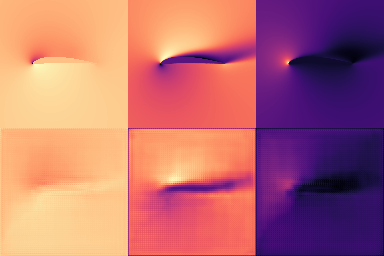

Validation sample 10, target (top) & model output (bottom)


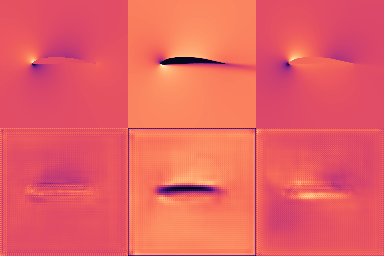

Validation sample 20, target (top) & model output (bottom)


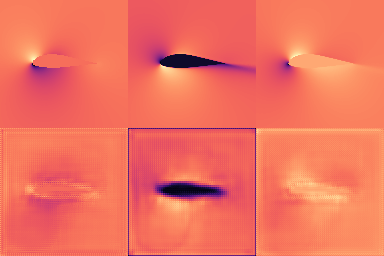

Validation sample 30, target (top) & model output (bottom)


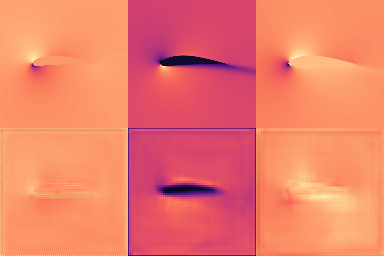

Validation sample 40, target (top) & model output (bottom)


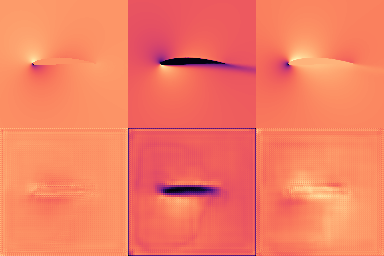

Validation sample 50, target (top) & model output (bottom)


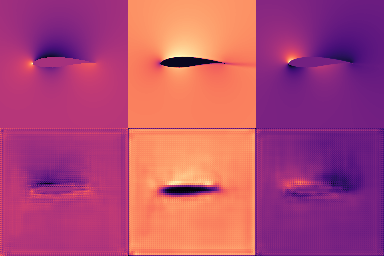

Validation sample 60, target (top) & model output (bottom)


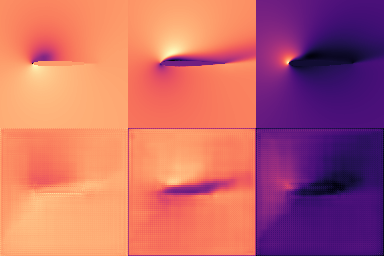

Validation sample 70, target (top) & model output (bottom)


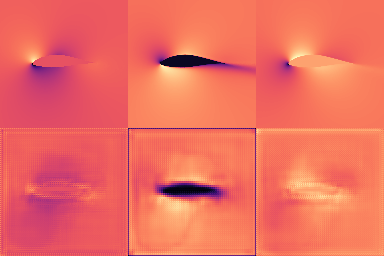

In [ ]:
#eval...

net.eval()
for i, validata in enumerate(valiLoader, 0):
    inputs_curr, targets_curr = validata
    inputs.data.copy_(inputs_curr.float())
    targets.data.copy_(targets_curr.float())

    outputs = net(inputs)
    outputs_curr = outputs.data.cpu().numpy()
    print("Validation sample {}, target (top) & model output (bottom)".format(i * batch_size) ) # only show each first one
    showSbs(targets_curr[0] , outputs_curr[0])


## Test evaluation

Now let's look at test samples, i.e. OOD, new airfoil shapes.
Never make conclusions about model error with training or validation samples, should come from test data set.

Loaded 10/10 test samples
Test samples: 10 
Validation sample 0, target (top) & model output (bottom)


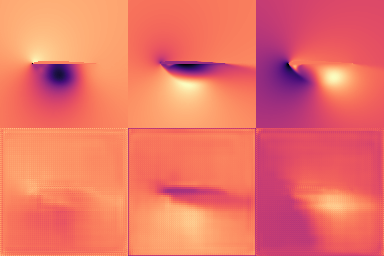

[0, 0.0405735969543457]
Validation sample 10, target (top) & model output (bottom)


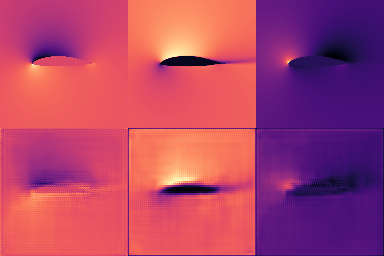

[1, 0.016509544104337692]
Validation sample 20, target (top) & model output (bottom)


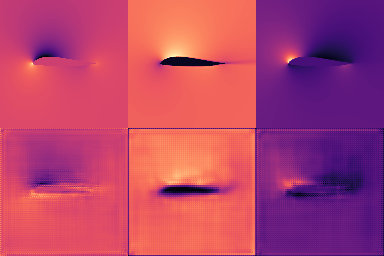

[2, 0.016246149316430092]
Validation sample 30, target (top) & model output (bottom)


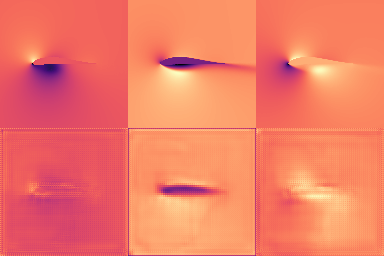

[3, 0.023604901507496834]
Validation sample 40, target (top) & model output (bottom)


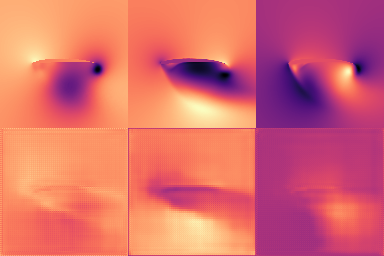

[4, 0.08236417174339294]
Validation sample 50, target (top) & model output (bottom)


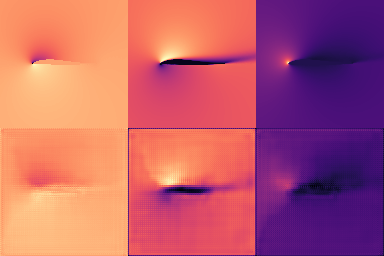

[5, 0.016082821413874626]
Validation sample 60, target (top) & model output (bottom)


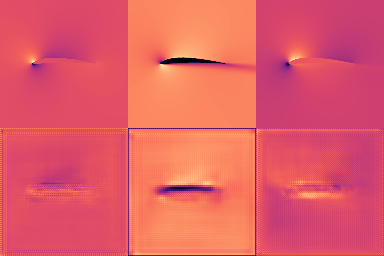

[6, 0.01607879064977169]
Validation sample 70, target (top) & model output (bottom)


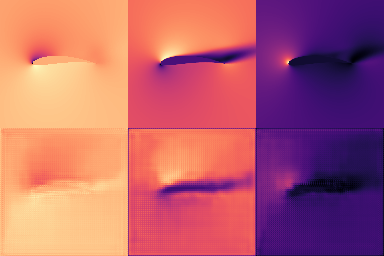

[7, 0.026996513828635216]
Validation sample 80, target (top) & model output (bottom)


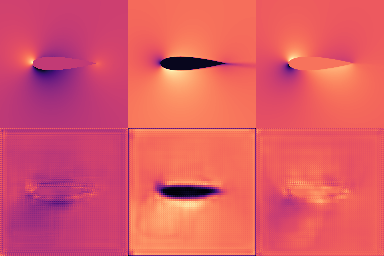

[8, 0.017805008217692375]
Validation sample 90, target (top) & model output (bottom)


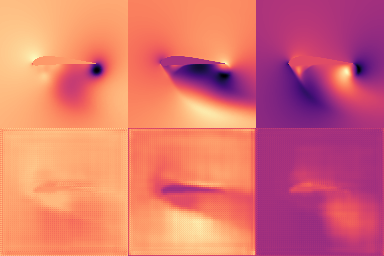

[9, 0.08684764057397842]
Average test error: 0.03431091383099556


In [ ]:
if not os.path.isfile('data_test.npz'):
  import urllib.request
  url="https://ge.in.tum.de/download/2019-deepFlowPred/data_test.npz"
  print("Downloading test data, this should be fast...")
  urllib.request.urlretrieve(url, 'data_test.npz')

nptfile=np.load("data_test.npz")
print("Loaded {}/{} test samples".format(len(nptfile["test_inputs"]),len(nptfile["test_targets"])))

testdata = DfpDataset(nptfile["test_inputs"],nptfile["test_targets"])
testLoader  = torch.utils.data.DataLoader(testdata, batch_size=1, shuffle=False, drop_last=True) 
print("Test samples: {} ".format(len(testLoader) ))

net.eval()
L1t_accum = 0.
for i, validata in enumerate(testLoader, 0):
    inputs_curr, targets_curr = validata
    inputs.data.copy_(inputs_curr.float())
    targets.data.copy_(targets_curr.float())

    outputs = net(inputs)
    outputs_curr = outputs.data.cpu().numpy()
    print("Validation sample {}, target (top) & model output (bottom)".format(i * batch_size) ) # only show each first one
    showSbs(targets_curr[0] , outputs_curr[0])

    lossL1t = criterionL1(outputs, targets)
    L1t_accum += lossL1t.item()
    print([i,lossL1t.item()])

print("Average test error: {}".format( L1t_accum/len(testLoader) ))

All done! Test error with current settings ca. 0.03, not too bad for new shapes, but clearly room for improvement. E.g., larger networks, longer training, larger data set etc.

Exercise: 
- change params to reduce error for test set
- TODO provide data with "errors" (nan & huge neg number in 1 cell), filter out to make model train...
